# Achieving Morphological Alignment

In [11]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import umap
import pickle as pk

## Loading Data

In [12]:
# This functions aligns a target array with the passed annotation dataframe using specimen ids
def align(array, specimen_ids, anno):
    aligned_array = np.stack([np.full_like(array[0], np.nan)] * len(anno))
    id_df = pd.DataFrame(data = {"specimen_id": specimen_ids, "alignment_index": range(len(specimen_ids))})
    id_df["specimen_id"] = id_df["specimen_id"].str.strip()
    aligned_indices = pd.merge(anno, id_df, on = "specimen_id", how = "inner")
    aligned_array[aligned_indices["row_index"].to_numpy()] =  array[aligned_indices["alignment_index"].to_numpy()]
    return aligned_array

# This function selects data from the target array based on which rows are present in the passed annotation
def select(array, anno):
    selected = array[anno["row_index"]]
    return selected

# This function samples from the passed dataframes to ensure that there is an equal number of samples
# from each experiment across excitatory cells and inhibitory cells
def normalize_sample_count(exp1, exp2, anno):
    unnormalized = anno.query("platform == @exp1 or platform == @exp2")
    exp1_exc = unnormalized.query("platform == @exp1 and `class` == 'exc'")
    exp1_inh = unnormalized.query("platform == @exp1 and `class` == 'inh'")
    exp2_exc = unnormalized.query("platform == @exp2 and `class` == 'exc'")
    exp2_inh = unnormalized.query("platform == @exp2 and `class` == 'inh'")
    if len(exp1_exc) > len(exp2_exc):
       exp1_exc = exp1_exc.sample(len(exp2_exc), replace = False)
    else:
        exp2_exc = exp2_exc.sample(len(exp1_exc), replace = False)
    if len(exp1_inh) > len(exp2_inh):
       exp1_inh = exp1_inh.sample(len(exp2_inh), replace = False)
    else:
        exp2_inh = exp2_inh.sample(len(exp1_inh), replace = False)
    anno_samp = pd.concat([exp1_exc, exp1_inh, exp2_exc, exp2_inh])
    return (unnormalized, anno_samp)

We begin by loading the arbor density, latent space, and cell annotation data, and restrict ourselves to only those cells where morphological data is available. This data is taken from EM, ME, fMOST, and Patch-Seq experiments.

In [13]:
# Load cell annotation file
anno_full = pd.read_csv("../data/raw/exc_inh_ME_fMOST_EM_specimen_ids_shuffled_4Apr23.txt").rename(columns = {"Unnamed: 0": "row_index"})
anno_full["specimen_id"] = anno_full["specimen_id"].str.strip()
# Load arbor density data (generated by data_proc_M.py in Fahimeh's cplAE_MET repository)
arbor_dict = sio.loadmat("../data/raw/M_arbor_data_50k_4Apr23.mat")
arbors = align(arbor_dict["hist_ax_de_api_bas"], arbor_dict["specimen_id"], anno_full) # Always align with unfiltered annotation
# Filter out cells which do not have valid morphological data
anno = anno_full.query("M_cell")
anno

row_index                specimen_id platform class  group  class_id  \
0              0  864691135274125285_199010       EM   exc      1       0.0   
2              2  864691135212658304_427884       EM   exc      1       0.0   
3              3  864691135354962383_392595       EM   exc      1       0.0   
5              5  864691136656750077_610633       EM   exc      1       0.0   
6              6  864691136898656366_396172       EM   exc      1       0.0   
...          ...                        ...      ...   ...    ...       ...   
52252      52252  864691135750158472_388862       EM   exc      1       0.0   
52254      52254  864691135373371848_297143       EM   exc      1       0.0   
52255      52255  864691135714363796_557060       EM   exc      1       0.0   
52256      52256  864691135587516402_491694       EM   exc      1       0.0   
52257      52257  864691136617413083_116088       EM   exc      1       0.0   

       T_cell  E_cell  M_cell  subgroup proofread  
0       False   False    True         1       NaN  
2       False   False    True         1       NaN  
3       False   False    True         1       NaN  
5       False   False    True         1       NaN  
6       False   False    True         1       NaN  
...       ...     ...     ...       ...       ...  
52252   False   False    True         1       NaN  
52254   False   False    True         1       NaN  
52255   False   False    True         1       NaN  
52256   False   False    True         1       NaN  
52257   False   False    True         1       NaN  

[45801 rows x 11 columns]

For each cell specimen, the arbor density data is an array of shape 120x4x4, except that the last dimension is split based on whether a cell is excitatory or inhibitory, with the index values 0 and 1 being reserved for inhibitory cells while values 2 and 3 are reserved for excitatory cells.

In [14]:
np.stack([arbors[0, 20:21], arbors[54, 20:21]]) # First array is an excitatory cell, second is an inhibitory cell

array([[[[0.        , 0.        , 0.84785634, 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]]],


       [[[0.        , 0.63299759, 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]]]])

Looking at the distribution of excitatory and inhibitory cells across the difference experiment types, we can see that there is a massive asymmetry for the EM data.

In [15]:
pd.pivot_table(anno, index = "platform", columns = "class", values = "row_index", aggfunc = "count")

class         exc    inh
platform                
EM        43314.0  141.0
ME          244.0  203.0
fMOST       280.0    NaN
patchseq    831.0  788.0

We will account for this by randomly sampling from the full dataset such that there are an equal number (831) of excitatory cells between the two datasets and an equal number (141) of inhibitory cells between the two datasets.

In [16]:
(exp1, exp2) = ("EM", "patchseq") # Any two of "EM", "patchseq", "ME", and "fMOST" can be used here for subsequent comparisons
(anno_unnorm, anno_samp) = normalize_sample_count(exp1, exp2, anno)

## Experimental Alignment

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

Our main concern is that there are disparities or misalignments between the different morphological platforms (e.g. EM vs Patch-seq) that leave a signature in the arbor density data. When training the multi-modal auto-encoder, these signatures can be exploited by the model to map the experimental platforms to different regions of the latent space, negating much of the benefit of using larger unimodal datasets during training.

One solution is to transform the different datasets to remove the platform signatures. We can design this transformation by using the output of an adversarial classifier as a guide, with our goal being to fool the classifier while minimizing the distance that we need to perturb the data.

We will focus initially on excitatory cells from EM and Patch-seq experiments, since these are the most abundant cell-experiment pairings.

In [18]:
anno_exc = anno_samp.query("`class` == 'exc'")
X_exc = select(arbors, anno_exc)[..., 2:].reshape((-1, 960)) # We use only the excitatory array slice, and then flatten the data
y_exc = np.where(anno_exc["platform"] == "EM", 0, 1) # Transform platform string array to a binary label vector suitable for ML
(X_train, X_test, y_train, y_test) = train_test_split(X_exc, y_exc, test_size = 0.25, random_state = 0)

### Classifier Lineup

We will want to explore using adversarial classifiers with differing levels of complexity to guide our alignment transformation. A reasonable lineup could consist of a linear classifier, QDA classifier, random forest classifier, and a dense neural network classifier. 

In [19]:
linear_classifier = RidgeClassifier(alpha = 5).fit(X_train, y_train)

In [20]:
qda_classifier = QDA(reg_param = 0.01).fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
tree_classifier = RandomForestClassifier(random_state = 0).fit(X_train, y_train)

In [ ]:
mlp_classifier = MLPClassifier((300, 200, 100), random_state = 0).fit(X_train, y_train)

In [ ]:
print(f"Linear classifier: {100*linear_classifier.score(X_test, y_test):.2f}%")
print(f"QDA classifier: {100*qda_classifier.score(X_test, y_test):.2f}%")
print(f"Random forest classifier: {100*tree_classifier.score(X_test, y_test):.2f}%")
print(f"Neural network classifier: {100*mlp_classifier.score(X_test, y_test):.2f}%")

The random forest model performed best, followed closely by the neural network. Their relatively high accuracies indicate that the experimental platforms are clearly discernible from the arbor density data, although separation is not perfect. Interestingly, the linear classifier (optimized using ridge regression) was somewhat competitive with the more complex models, and outperformed the QDA classifier.

### Alignment Transformations

With these adversarial models in hand, we now seek a transformation that can fool them. Specifically, we want to perturb the Patch-seq samples such that they cannot be reliably distinguished from the EM samples. This alone is not a very difficult or meaningful goal, since we could just take each Patch-seq sample and place it on top of an EM sample to make classification impossible. Instead, we want to find a transformation that fools the classifiers while *minimally* altering the arbor densities, thus preserving as much information as possible.

#### The Naive Approach

For something simple like the linear classifier, this transformation can be computed analytically. We simply project onto the coefficient vector and move along it by an amount equal to the difference between the desired classifier output and the initial output (normalized by the norm of the coefficients). In this case, our desired output is the decision boundary located at 0, or the initial output if it is already less than 0. Any perturbation component perpendicular to the coefficient vector will not affect the classifier's output, and must be avoided to minimize alteration of the arbor densities as measured by the L2 distance.

In [ ]:
def linear_correction(X, y, coef, buffer = 1e-10):
    output_dist = -(y[:, None] + buffer)
    coef_norm = np.sum(coef**2)
    delta = coef[None] * output_dist / coef_norm
    delta[y < -buffer] = 0
    corrected = X + delta
    return corrected

To verify that this transformation is effective, we can look at the classification accuracy for Patch-seq samples before and after they have been perturbed. We expect that the initial accuracy will be around 80%, while the perturbed accuracy should be 0%. We can also quantify the the size of the perturbation using the L2 distance.

In [ ]:
(X_patch_train, y_patch_train) = (X_train[y_train == 1], y_train[y_train == 1])
(X_patch_test, y_patch_test) = (X_test[y_test == 1], y_test[y_test == 1])
X_patch_train_corr = linear_correction(X_patch_train, linear_classifier.decision_function(X_patch_train), linear_classifier.coef_[0])
X_patch_test_corr = linear_correction(X_patch_test, linear_classifier.decision_function(X_patch_test), linear_classifier.coef_[0])

In [ ]:
uncorr_score = linear_classifier.score(X_patch_test, y_patch_test)
corr_score = linear_classifier.score(X_patch_test_corr, y_patch_test)
perturb_size = np.linalg.norm(X_patch_test - X_patch_test_corr, axis = 1).mean()
print(f"Linear clasifier Patch-seq accuracy before correction: {100*uncorr_score:.2f}%")
print(f"Linear clasifier Patch-seq accuracy after correction: {100*corr_score:.2f}%")
print(f"Arbor densities perturbed by an average of {perturb_size:.4f} in L2 distance ({perturb_size / 960:.2g} per feature).")

We can also inspect how the accuracies of the other classifiers have been affected by the transformation.

In [ ]:
print(f"QDA classifier Patch-seq accuracy after correction: {100*qda_classifier.score(X_patch_test_corr, y_patch_test):.2f}%")
print(f"Random forest classifier Patch-seq accuracy after correction: {100*tree_classifier.score(X_patch_test_corr, y_patch_test):.2f}%")
print(f"Neural network classifier Patch-seq accuracy after correction: {100*mlp_classifier.score(X_patch_test_corr, y_patch_test):.2f}%")

Critically, the accuracies of the other classifiers are not strongly impacted. This is perhaps not surprising, since we would expect different classifiers to have different (and more complicated) decision boundaries than the linear model. Even if the Patch-seq data is moved far over the linear classifier's decision boundary—by increasing the "buffer" argument in `linear_correction` to, say, 10—both the QDA and random forrest classifiers are largely unaffected (the neural network is completely fooled).

As a final test, we can re-train the linear classifier on the corrected data, and check if we have even suceeded in removing the linearly-separable signatures.

In [ ]:
X_train_corr = np.concatenate([X_train[y_train == 0], X_patch_train_corr], axis = 0)
y_train_corr = np.concatenate([y_train[y_train == 0], y_patch_train], axis = 0)
linear_classifier_corr = RidgeClassifier().fit(X_train_corr, y_train_corr)
print(f"New linear classifier trained after correction: {100*linear_classifier_corr.score(X_patch_test_corr, y_patch_test):.2f}%")

coef_uncorr = linear_classifier.coef_[0]
coef_corr = linear_classifier_corr.coef_[0]
cos = np.dot(coef_uncorr, coef_corr) / (np.linalg.norm(coef_uncorr)*np.linalg.norm(coef_corr))
print(f"Cosine of angle between corrected and uncorrected coefficient vectors: {cos:.4f}")

Based on these results, it is clear that a linear decision boundary still exists between the EM and Patch-seq arbor densities after our transformation, and its performance is equivalent to that of the original boundary.

#### Closing the Separation Gap

An obvious weakness of the previous strategy is that we targeted only a single hyperplane. If our goal is to prevent the EM and Patch-seq samples from being distinguished by *any* linear classifier, then we will want to transform the data such that no hyperplane can induce consistent separation of the data.

It turns out that we can find this transformation analytically for an ordinary least-squares classifier, since the coefficients are given by
$$
\vec{\beta} = [\text{E}(\vec{x} \otimes \vec{x})]^{-1} \cdot \text{E}[y\cdot\vec{x}].
$$
In our classification task, $y = \pm 1$ for Patch-seq and EM samples respectively, so the second averaging operation simplifies to
$$
\text{E}[y \cdot \vec{x}] = \text{E}_{patch}[\vec{x}]\cdot \text{Prob}(patch) - \text{E}_{EM}[\vec{x}]\cdot \text{Prob}(EM).
$$
Since we are using a roughly equal number of EM and Patch-seq samples, the entire vector of regression coefficients can be made to vanish if the mean of the Patch-seq data is transformed so as to coincide with that of the EM data. This will lead to a mean-square error of 1, which is the largest possible minimum error for any balanced classification task with $y = \pm 1$ (any larger value would require suboptimal coefficients to be deliberately chosen).

In [19]:
offset = 1*(X_train[y_train == 0].mean(0, keepdims = True) - X_patch_train.mean(0, keepdims = True))
print(f"L2-norm of mean perturbation: {np.linalg.norm(offset):.2f}")

L2-norm of mean perturbation: 12.01


To see how this transformation will affect the accuracy of our classifier lineup, we can re-train them on the aligned data.

In [20]:
X_train_offset = np.concatenate([X_train[y_train == 0], X_patch_train + offset])
y_train_offset = np.concatenate([y_train[y_train == 0], y_train[y_train == 1]])
X_test_offset = np.concatenate([X_test[y_test == 0], X_patch_test + offset])
y_test_offset = np.concatenate([y_test[y_test == 0], y_test[y_test == 1]])

In [21]:
linear_classifier_offset = RidgeClassifier(alpha = 5).fit(X_train_offset, y_train_offset)

In [22]:
qda_classifier_offset = QDA(reg_param = 0.01).fit(X_train_offset, y_train_offset)

C:\Users\Public\miniconda3\envs\cpl\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [23]:
tree_classifier_offset = RandomForestClassifier(random_state = 0).fit(X_train_offset, y_train_offset)

In [24]:
mlp_classifier_offset = MLPClassifier((300, 200, 100), random_state = 0).fit(X_train_offset, y_train_offset)

In [25]:
print(f"Linear classifier: {100*linear_classifier_offset.score(X_patch_test + offset, y_patch_test):.2f}%")
print(f"QDA classifier: {100*qda_classifier_offset.score(X_patch_test + offset, y_patch_test):.2f}%")
print(f"Random forest classifier: {100*tree_classifier_offset.score(X_patch_test + offset, y_patch_test):.2f}%")
print(f"Neural network classifier: {100*mlp_classifier_offset.score(X_patch_test + offset, y_patch_test):.2f}%")

Linear classifier: 0.00%
QDA classifier: 81.04%
Random forest classifier: 100.00%
Neural network classifier: 100.00%


These results are quite telling. We have indeed fooled the linear classifier, but the performances of the other classifiers have either remained the same or *improved*. The gains of the random forest and neural network classifiers are especially dramatic, as they are now able to almost perfectly distinguish Patch-seq and EM samples. In our attempt to remove the linearly-separable portion of the experiment signature, we have unintentionally stamped an even more obvious non-linear signature. Good grief.

To further examine the viablity of this transformation, we can perturb the data by small steps and see how the gain in accuracy of the neural network model compares to the loss in accuracy of the ridge classifier. We will also add in a logistic regression classifier, to verify that other linear models are also defeated by the mean perturbation.

In [26]:
steps = np.linspace(0, 0.9, 10)
X_partial_offsets = [np.concatenate([X_train[y_train == 0], X_patch_train + step*offset]) for step in steps]
mlp_models = [MLPClassifier((300, 200, 100), random_state = 0).fit(X, y_train_offset) for (step, X) in zip(steps, X_partial_offsets)]
mlp_accuracies = [model.score(X_patch_test + step*offset, y_patch_test) for (step, model) in zip(steps, mlp_models)]
ridge_models = [RidgeClassifier(alpha = 5).fit(X, y_train_offset) for (step, X) in zip(steps, X_partial_offsets)]
ridge_accuracies = [model.score(X_patch_test + step*offset, y_patch_test) for (step, model) in zip(steps, ridge_models)]
logistic_models = [LogisticRegression(max_iter = 10000).fit(X, y_train_offset) for (step, X) in zip(steps, X_partial_offsets)]
logistic_accuracies = [model.score(X_patch_test + step*offset, y_patch_test) for (step, model) in zip(steps, logistic_models)]

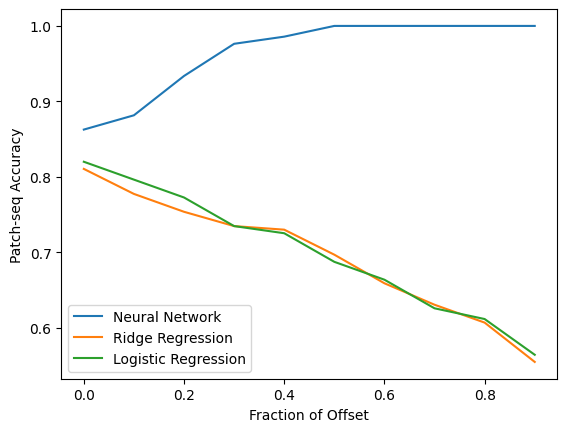

In [27]:
plt.plot(steps, mlp_accuracies, label = "Neural Network")
plt.plot(steps, ridge_accuracies, label = "Ridge Regression")
plt.plot(steps, logistic_accuracies, label = "Logistic Regression")
plt.xlabel("Fraction of Offset")
plt.ylabel("Patch-seq Accuracy")
plt.legend()
plt.show()

These curves show how sensitive the neural network model is to the mean-alignment transformation. After closing only half of the gap, the MLP classifier can already achieve near-perfect separation, and at no point does its accuracy ever significantly decrease as the Patch-seq and EM means are brought closer together. As such, this kind of perturbation does not appear to fool non-linear models, and it can actually improve their performance.

### Alignment via Neural Network

While our results for the linear models were disapointing, it is worth exploring whether the other classifiers can lead us to more substantive alignment transformations. For these more complicated models, it can be difficult or impossible to analytically derive a transformation that will fool the classifier while also minimzing the perturbation distance. One solution is to use a flexible learning algorithm such as a neural network to parameterize the transformation function, and then train it to balance classification (in)accuracy with reconstruction error. The resulting network can then be used as a black-box model to align the different experimental platforms.

Given the relative paucity of Patch-seq data, we will want to use a fairly simple neural network model. It will take as input the flattened arbor densities (N x 960 array), and output an identically-sized perturbation.

In [134]:
class Aligner(torch.nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.layer_names = []
        all_dims = [960] + list(hidden_dims) + [960]
        for (i, (in_dim, out_dim)) in enumerate(zip(all_dims[:-1], all_dims[1:]), 1):
            setattr(self, f"l{i}", torch.nn.Linear(in_dim, out_dim))
            self.layer_names.append(f"l{i}")
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        for layer_name in self.layer_names[:-1]:
            layer = getattr(self, layer_name)
            X = self.relu(layer(X))
        final_layer = getattr(self, self.layer_names[-1])
        output = torch.nn.functional.softplus(final_layer(X))
        return output

The classifier will likewise be a simple feedforward network, with a `get_loss` method that takes Patch-seq samples and outputs the cross-entropy loss.

In [29]:
class Classifier(torch.nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.layer_names = []
        all_dims = [960] + list(hidden_dims) + [1]
        for (i, (in_dim, out_dim)) in enumerate(zip(all_dims[:-1], all_dims[1:]), 1):
            setattr(self, f"l{i}", torch.nn.Linear(in_dim, out_dim))
            self.layer_names.append(f"l{i}")
        self.relu = torch.nn.ReLU()

    def get_loss(self, X):
        log_odds = self(X)[:, 0]
        labels = torch.zeros(X.shape[0]).to(X.device).long()
        loss = torch.nn.functional.cross_entropy(torch.stack([-log_odds, log_odds], 1), labels)
        return loss

    def forward(self, X):
        for layer_name in self.layer_names[:-1]:
            layer = getattr(self, layer_name)
            X = self.relu(layer(X))
        final_layer = getattr(self, self.layer_names[-1])
        output = final_layer(X)
        return output

Both of these models will consume arbor density data from a simple PyTorch Dataset object:

In [30]:
class ExcDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, device):
        super().__init__()
        self.X = torch.from_numpy(X).float().to(device)
        self.y = torch.from_numpy(y).to(device)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

During training, we will want to optimize the aligner and classifier during each epoch. Their learning rates can be set independently in order to control how well one model is able to conform to the other. The classifier will be trained to minimize the cross-entropy loss when classifying EM and Patch-seq samples, while the aligner model will be trained to maximize the cross-entropy loss of the classifier for the Patch-seq samples. This sets up an adversarial optimization environment, which will hopefully teach the aligner model how to fool *any* neural network classifier (within reason).

In [31]:
def optim_aligner(aligner, classifier, optimizer, patch_arbors, norm_scale, norm_loss_frac):
    optimizer.zero_grad()
    perturbation = aligner(patch_arbors)
    aligned_arbors = perturbation #patch_arbors + perturbation
    norm_loss = torch.linalg.norm(perturbation - patch_arbors, dim = 1).mean() #torch.linalg.norm(perturbation, dim = 1).mean()
    classifier_loss = classifier.get_loss(aligned_arbors)
    loss = norm_loss_frac*norm_scale*norm_loss + (1 - norm_loss_frac)*classifier_loss
    loss.backward()
    optimizer.step() 
    return (norm_loss, classifier_loss)

In [32]:
def optim_classifier(aligner, classifier, optimizer, patch_arbors, em_arbors):
    (num_em, num_patch) = (em_arbors.shape[0], patch_arbors.shape[0])
    optimizer.zero_grad()
    perturbation = aligner(patch_arbors)
    aligned_arbors = perturbation #patch_arbors + perturbation
    labels = torch.cat([torch.zeros(num_em), torch.ones(num_patch)]).long().to(patch_arbors.device)
    log_odds = classifier(torch.cat([em_arbors, aligned_arbors]))[:, 0]
    loss = torch.nn.functional.cross_entropy(torch.stack([-log_odds, log_odds], 1), labels)
    loss.backward()
    optimizer.step()
    correct = (log_odds[:num_em] < 0).int().sum() + (log_odds[num_em:] > 0).int().sum()
    return (aligned_arbors, correct)

In [33]:
def run_validation(aligner, classifier, patch_val, em_val):
    perturbation = aligner(patch_val)
    aligned = patch_val + perturbation
    correct = (classifier(patch_val) > 0).int().sum() + (classifier(em_val) > 0).int().sum()
    norm_loss = torch.linalg.norm(perturbation, dim = 1).mean()
    class_loss = classifier.get_loss(patch_val)
    return (norm_loss, class_loss, correct)

Since the classifier model optimized via this process will be intimately tied to the aligner model. we will want to validate the effectiveness of the resulting alignment using a set of "third-party" classifiers. A set of these model can be trained and evaluated periodically during training, in order to verify that the perturbation can truly generalize to models other than the adversarial classifier. Unfortunately, we cannot use the same train/test split that was used to optimize the aligner, since there is no guarantee that the perturbation is consistent for out-of-sample data. Instead, we can further divide the training set (since it is much larger) into two subsets, and train our third-party classifiers on this split. This will be a best-case scenario (versus using the validation data) for the aligner, and thus function as an upper-bound for its effectivness.

In [34]:
def fit_validators(aligned_arbors, em_arbors, val_count = 100):
    X_train = torch.cat([em_arbors[val_count:], aligned_arbors[val_count:]]).detach().cpu().numpy()
    X_test = torch.cat([em_arbors[:val_count], aligned_arbors[:val_count]]).detach().cpu().numpy()
    y_train = np.concatenate([-np.ones([em_arbors.shape[0] - 100]), np.ones([aligned_arbors.shape[0] - 100])])
    y_test = np.concatenate([-np.ones([100]), np.ones([100])])
    ridge_acc = RidgeClassifier(alpha = 5).fit(X_train, y_train).score(X_test, y_test)
    forest_acc = RandomForestClassifier().fit(X_train, y_train).score(X_test, y_test)
    mlp_acc = MLPClassifier(((300, 200, 100))).fit(X_train, y_train).score(X_test, y_test)
    return (ridge_acc, forest_acc, mlp_acc)

In [35]:
def print_results(results, epoch):
    (norm, entropy) = results["metrics"][:2] / results["count"][0]
    acc = results["metrics"][2] / results["count"].sum()
    (val_norm, val_entropy) = results["val_metrics"][:2] / results["val_count"][0]
    val_acc = results["val_metrics"][2] / results["val_count"].sum()
    print(f"Epoch {epoch} ----------------------------------------------")
    print(f"Training Perturbation Norm: {norm:.4f} | Training Classification Loss: {entropy:.4f} | Training Accuracy: {100*acc:.2f}%")
    print(f"Validation Perturbation Norm: {val_norm:.4f} | Validation Classification Loss: {val_entropy:.4f} | Validation Accuracy: {100*val_acc:.2f}%")
    if "validators" in results:
        (ridge_acc, forest_acc, mlp_acc) = results["validators"]
        print(f"Ridge: {100*ridge_acc:.2f}% | Random Forest: {100*forest_acc:.2f}% | Neural Network: {100*mlp_acc:.2f}%")

Putting this all together produces the following training loop:

In [36]:
def train(aligner, classifier, train_loader, val_loader, em_arbors, em_val_arbors, epochs, aligner_lr, classifier_lr, norm_loss_frac):
    norm_scale = 1
    aligner_optimizer = torch.optim.Adam(aligner.parameters(), lr = aligner_lr)
    classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr = classifier_lr)
    all_results = []
    for epoch in range(epochs):
        epoch_results = {"count": np.zeros([2]), "metrics": np.zeros([3]), "val_count": np.zeros([2]), "val_metrics": np.zeros([3])}
        for (step, (patch_arbors, specimen_ids)) in enumerate(iter(train_dataloader), 1):
            (norm_loss, classifier_loss) = optim_aligner(aligner, classifier, aligner_optimizer, 
                                                                       patch_arbors, norm_scale, norm_loss_frac)
            (aligned_arbors, correct) = optim_classifier(aligner, classifier, classifier_optimizer, patch_arbors, em_arbors)
            with torch.no_grad():
                norm_scale = (classifier_loss / norm_loss if (type(norm_scale) == int) else norm_scale)
            epoch_results["metrics"] += np.asarray([norm_loss.item()*patch_arbors.shape[0], classifier_loss.item()*patch_arbors.shape[0], correct.item()])
            epoch_results["count"] += np.asarray([patch_arbors.shape[0], em_arbors.shape[0]])
        with torch.no_grad():
            for (val_arbors, _) in iter(val_dataloader):
                (val_norm_loss, val_classifier_loss, val_correct) = run_validation(aligner, classifier, val_arbors, em_val_arbors)
                epoch_results["val_metrics"] += np.asarray([val_norm_loss.item()*val_arbors.shape[0], val_classifier_loss.item()*val_arbors.shape[0], val_correct.item()])
                epoch_results["val_count"] += np.asarray([val_arbors.shape[0], em_val_arbors.shape[0]])
            if epoch % 10 == 1000 or epoch + 1 == epochs:
                epoch_results["validators"] = fit_validators(aligned_arbors, em_arbors)
        all_results.append(epoch_results)
        print_results(epoch_results, epoch + 1)
    return all_results

To train the model, we must specify a set of hyperparameters, create the training and testing dataloaders, initialize the aligner and classifier models, and then call `train`.

In [130]:
device = "cuda"
num_epochs = 10000
batch_size = 2048
aligner_hidden_dims = (100, 10, 100)
classifier_hidden_dims = [300, 200, 100]
aligner_lr = 1e-3
classifier_lr = 1e-5
norm_loss_frac = 1

In [131]:
train_dataset = ExcDataset(X_train[y_train == 1], y_train[y_train == 1], device)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataset = ExcDataset(X_test[y_test == 1], y_test[y_test == 1], device)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1024)

(X_em_train, X_em_test) = (X_train[y_train == 0], X_test[y_test == 0])
(X_patch_test, y_patch_test) = (X_test[y_test == 1], y_test[y_test == 1])

In [132]:
aligner = Aligner(classifier_hidden_dims)
classifier = Classifier(classifier_hidden_dims)

In [133]:
results = train(aligner.float().to(device), classifier.float().to(device), train_dataloader, val_dataloader, 
                torch.from_numpy(X_em_train).float().to(device), torch.from_numpy(X_em_test).float().to(device), 
                num_epochs, aligner_lr, classifier_lr, norm_loss_frac)

Epoch 1 ----------------------------------------------
Training Perturbation Norm: 38.0851 | Training Classification Loss: 0.6688 | Training Accuracy: 50.08%
Validation Perturbation Norm: 1.9832 | Validation Classification Loss: 0.6343 | Validation Accuracy: 0.24%
Epoch 2 ----------------------------------------------
Training Perturbation Norm: 37.9356 | Training Classification Loss: 0.6688 | Training Accuracy: 50.24%
Validation Perturbation Norm: 2.4400 | Validation Classification Loss: 0.6324 | Validation Accuracy: 0.00%
Epoch 3 ----------------------------------------------
Training Perturbation Norm: 37.8152 | Training Classification Loss: 0.6690 | Training Accuracy: 50.24%
Validation Perturbation Norm: 2.9654 | Validation Classification Loss: 0.6305 | Validation Accuracy: 0.00%
Epoch 4 ----------------------------------------------
Training Perturbation Norm: 37.6925 | Training Classification Loss: 0.6691 | Training Accuracy: 50.24%
Validation Perturbation Norm: 3.5683 | Validati

With the aligner model trained, we can plot the third-party validatory accuracies across different epochs. We would hope to see evidence that their ability to separate EM and Patch-seq samples is diminished.

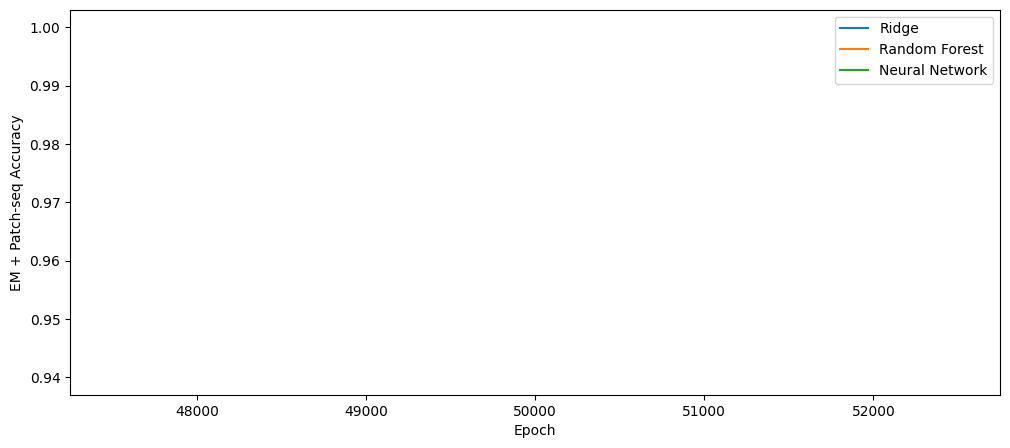

In [105]:
accs = [(epoch, result_dict["validators"]) for (epoch, result_dict) in enumerate(results, 1) if "validators" in result_dict]
epochs = [epoch for (epoch, _) in accs]
(ridge_accs, forest_accs, mlp_accs) = ([tupl[1][0] for tupl in accs], [tupl[1][1] for tupl in accs], [tupl[1][2] for tupl in accs])
plt.plot(epochs, ridge_accs, label = "Ridge")
plt.plot(epochs, forest_accs, label = "Random Forest")
plt.plot(epochs, mlp_accs, label = "Neural Network")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("EM + Patch-seq Accuracy")
plt.show()

Unfortunately, we do not see evidence of this. All three classifier achieve near perfect accuracy, with the neural network classifier experiencing some minor fluctuations. To see whether this is an issue of perturbation magnitude rather than direction, we can repeat the same fractional-offset analysis that was done for the mean-alignment method.

In [ ]:
(em_arbors, patch_arbors) = (torch.from_numpy(X_train[y_train == 0]), torch.from_numpy(X_train[y_train == 1]))
with torch.no_grad():
    perturbation = aligner(patch_arbors.to(next(aligner.parameters()))).cpu().numpy()
fracs = np.linspace(0, 1, 11)
frac_accs = [fit_validators(patch_arbors + frac*perturbation, em_arbors) for frac in fracs]
(ridge_frac, forest_frac, mlp_frac) = ([tupl[0] for tupl in frac_accs], [tupl[1] for tupl in frac_accs], [tupl[2] for tupl in frac_accs])

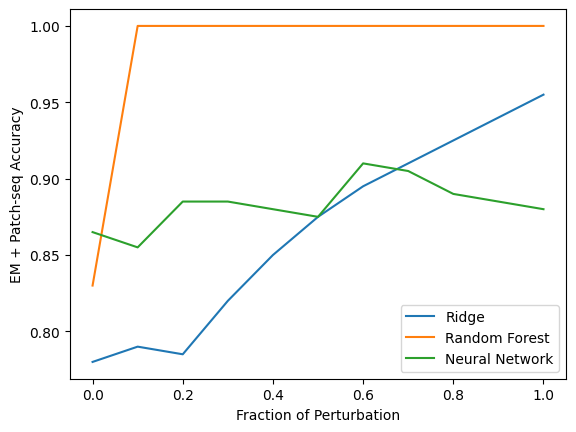

In [89]:
plt.plot(fracs, ridge_frac, label = "Ridge")
plt.plot(fracs, forest_frac, label = "Random Forest")
plt.plot(fracs, mlp_frac, label = "Neural Network")
plt.legend()
plt.xlabel("Fraction of Perturbation")
plt.ylabel("EM + Patch-seq Accuracy")
plt.show()

Again, the results are disappointing. Even at very small fractions, the aligner's perturbation leads to improved performance across all three models, with no evidence of any generalized effectivness.

### Sparsity Troubles?

So what went wrong?

In [117]:
aligned = aligner(torch.from_numpy(X_train[y_train == 1]).cuda().float()).detach().cpu().numpy()
em_log = np.log10(X_train[y_train == 0])
em_log[X_train[y_train == 0] == 0] = 0
patch_log = np.log10(X_train[y_train == 1])
patch_log[X_train[y_train == 1] == 0] = 0
aligned_log = np.log10(abs(aligned))
aligned_log[aligned == 0] = 0

C:\Users\Ian Convy\AppData\Local\Temp\ipykernel_14036\1156127254.py:2: RuntimeWarning: divide by zero encountered in log10
  em_log = np.log10(X_train[y_train == 0])
C:\Users\Ian Convy\AppData\Local\Temp\ipykernel_14036\1156127254.py:4: RuntimeWarning: divide by zero encountered in log10
  patch_log = np.log10(X_train[y_train == 1])
C:\Users\Ian Convy\AppData\Local\Temp\ipykernel_14036\1156127254.py:6: RuntimeWarning: divide by zero encountered in log10
  aligned_log = np.log10(abs(aligned))


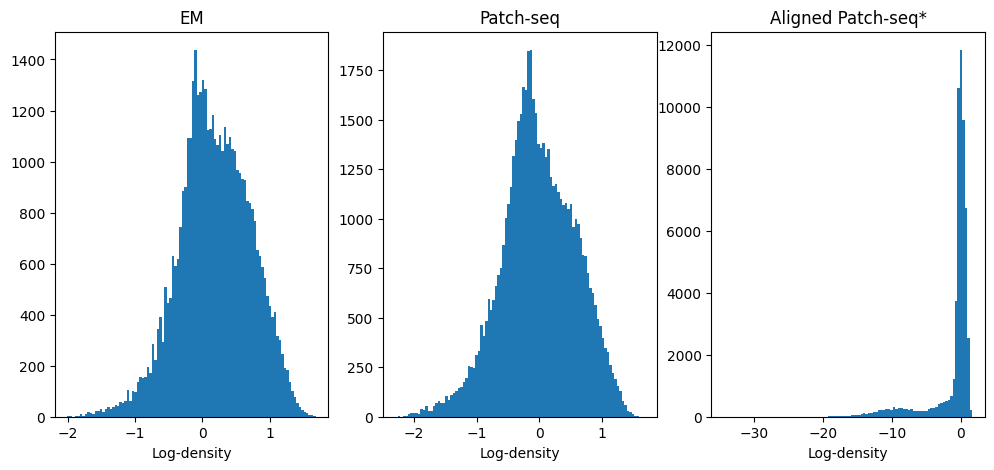

In [120]:
(fig, (ax_1, ax_2, ax_3)) = plt.subplots(1, 3, figsize = (12, 5))
ax_1.hist(em_log.flatten()[em_log.flatten() != 0], bins = 100)
ax_1.set_title("EM")
ax_1.set_xlabel("Log-density")
ax_2.hist(patch_log.flatten()[patch_log.flatten() != 0], bins = 100)
ax_2.set_title("Patch-seq")
ax_2.set_xlabel("Log-density")
ax_3.hist(aligned_log.flatten()[(aligned_log.flatten() != 0) & (patch_log.flatten() != 0)], bins = 100)
ax_3.set_title("Aligned Patch-seq*")
ax_3.set_xlabel("Log-density")
plt.show()

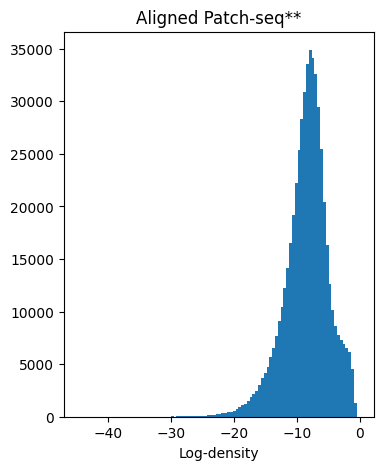

In [121]:
(fig, ax_1) = plt.subplots(1, 1, figsize = (4, 5))
ax_1.hist(aligned_log.flatten()[patch_log.flatten() == 0], bins = 100)
ax_1.set_title("Aligned Patch-seq**")
ax_1.set_xlabel("Log-density")
plt.show()

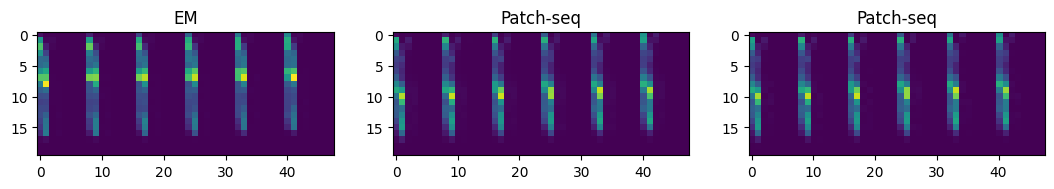

In [122]:
em_mean = X_train[y_train == 0].mean(0)
patch_mean = X_train[y_train == 1].mean(0)
aligned_mean = abs(aligned).mean(0)
(fig, (ax_1, ax_2, ax_3)) = plt.subplots(1, 3, figsize = (13, 5))
ax_1.imshow(em_mean.reshape(20, 48), vmin = 0, vmax = max(em_mean.max(), patch_mean.max(), aligned_mean.max()))
ax_1.set_title("EM")
ax_2.imshow(patch_mean.reshape(20, 48), vmin = 0, vmax = max(em_mean.max(), patch_mean.max(), aligned_mean.max()))
ax_2.set_title("Patch-seq")
ax_3.imshow(aligned_mean.reshape(20, 48), vmin = 0, vmax = max(em_mean.max(), patch_mean.max(), aligned_mean.max()))
ax_3.set_title("Patch-seq")
plt.show()

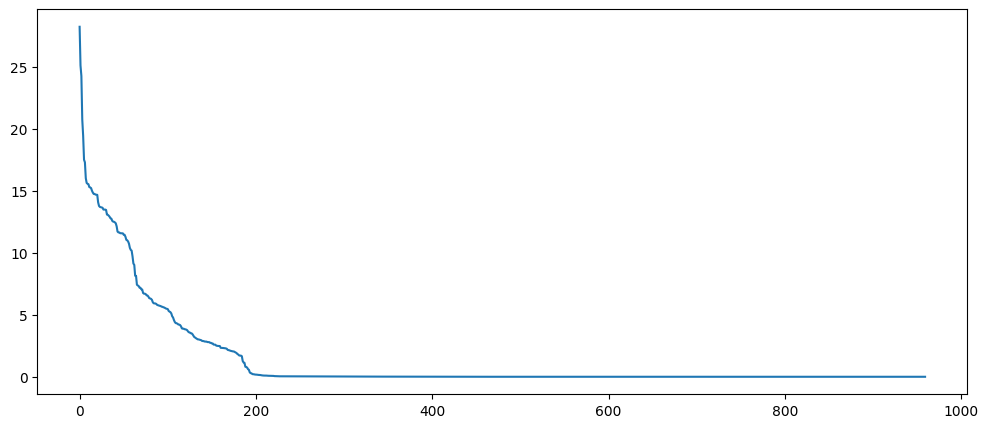

In [123]:
variance = np.var(X_train, axis = 0)
var_indices = np.argsort(variance)
plt.plot(np.flip(variance[var_indices]))
plt.show()

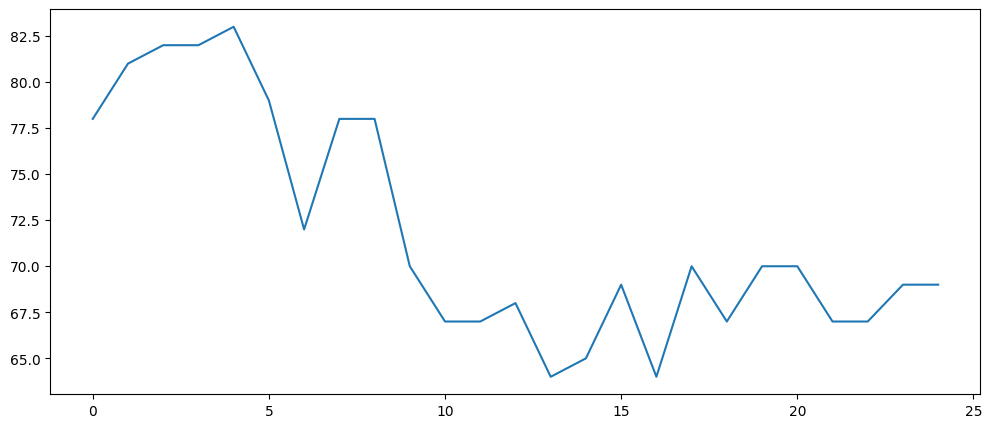

In [128]:
perturbation = aligned - X_train[y_train == 1]
low_high = []
indices = np.flip(var_indices)
for step in range(0, len(variance) + 1, 40):
    print(step, end = "\r")
    delta = perturbation.copy()
    delta[:, indices[:step]] = 0
    data = X_train.copy() + np.random.normal(0, 1e-2, X_train.shape)
    data[y_train == 1] = data[y_train == 1] + delta 
    # low_high.append(100*RandomForestClassifier().fit(data[100:], y_train[100:]).score(data[:100], y_train[:100]))
    low_high.append(100*RidgeClassifier(alpha = 0.1).fit(data[100:], y_train[100:]).score(data[:100], y_train[:100]))
plt.plot(low_high)
plt.show()

In [105]:
low_high

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,


In [97]:
fit_validators(torch.from_numpy(X_train[y_train == 0]), torch.from_numpy(X_train[y_train == 1]))

(0.73, 0.855, 0.825)

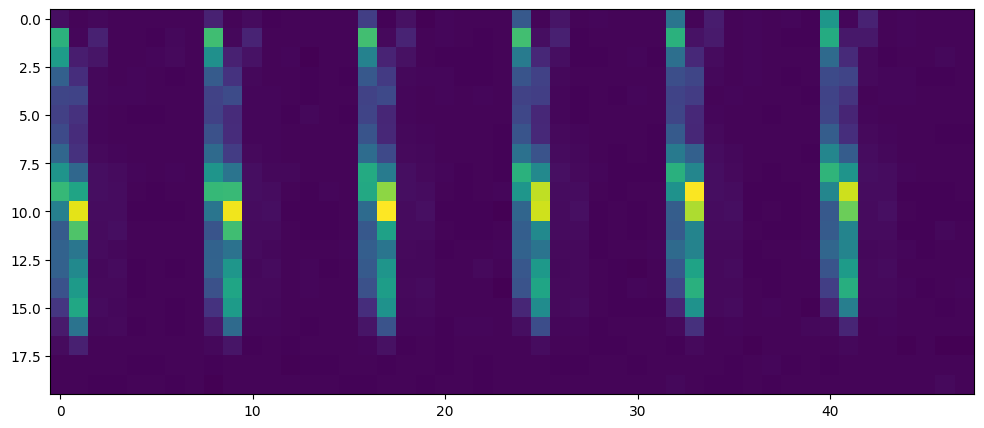

In [114]:
aligned = aligner(torch.from_numpy(X_train[y_train == 1]).cuda().float()).detach().cpu().numpy()
(fig, ax_1) = plt.subplots(1, 1)
ax_1.imshow(aligned.mean(0).reshape(20, 48))
plt.show()

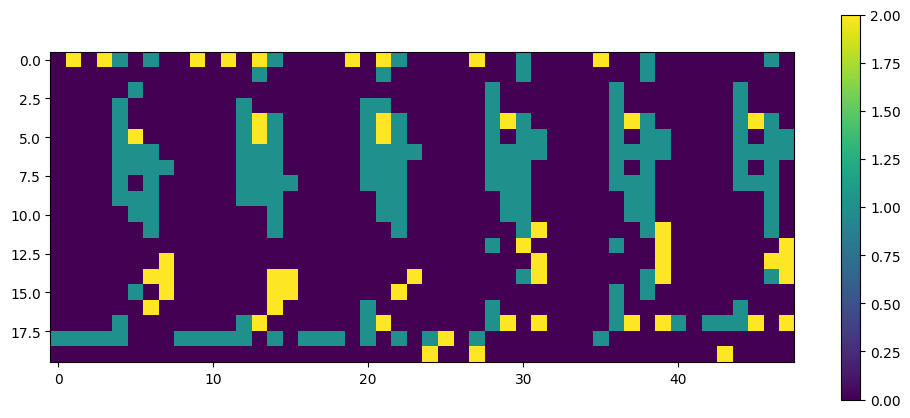

True


In [136]:
em_blank = (em_mean == 0)
patch_blank = (patch_mean == 0)
aligned_blank = (aligned.mean(0) == 0)
all_blank = patch_blank & em_blank & aligned_blank
only_patch = patch_blank & ~em_blank
only_em = em_blank & ~patch_blank
only_aligned = aligned_blank & ~patch_blank & ~em_blank
code = aligned_blank*4
code[only_em] = 1
code[only_patch] = 2
code[only_aligned] = 3
plt.imshow(code.reshape(20, 48))
plt.colorbar()
plt.show()
print(em_blank.any())

### Coupled-AE Clustering

In [127]:
with open("../data/remote/coupled_mt/output.pkl", "rb") as target:
    outputs = pk.load(target)
spec_ids = outputs["specimen_id"]
zm = align(outputs["zm"], spec_ids, anno_full)
types = align(outputs["class"], spec_ids, anno_full)
platforms = anno_full["platform"].to_numpy()

In [128]:
valid = ~np.any(np.isnan(zm), 1) & anno_full["M_cell"].to_numpy()
zm = zm[valid]
types = types[valid]
platforms = platforms[valid]

In [129]:
np.unique(platforms, return_counts = True)

(array(['EM', 'ME', 'fMOST', 'patchseq'], dtype=object),
 array([5009,  447,  280, 1619]))

In [130]:
umap_model = umap.UMAP(n_components = 3).fit(zm)

In [131]:
proj = umap_model.transform(zm)

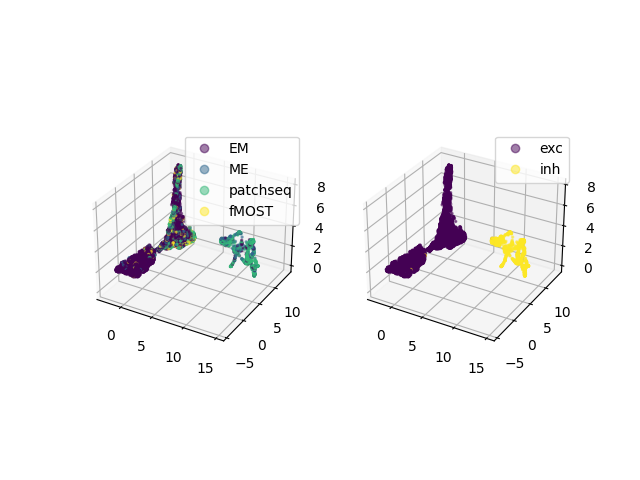

In [132]:
%matplotlib widget
fig = plt.figure()
ax_exp = fig.add_subplot(1, 2, 1, projection = "3d")
ax_type = fig.add_subplot(1, 2, 2, projection = "3d")
(factors_exp, labels_exp) = pd.Series(platforms).factorize() # For legend to match color with label
(factors_type, labels_type) = pd.Series(types).factorize() # For legend to match color with label
sc_exp = ax_exp.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s = 2, alpha = 0.5, 
                c = factors_exp)
sc_type = ax_type.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s = 2, alpha = 0.5, 
                c = factors_type)
leg_exp = ax_exp.legend(sc_exp.legend_elements()[0], labels_exp.to_list())
leg_type = ax_type.legend(sc_type.legend_elements()[0], labels_type.to_list())
plt.show()

In [133]:
from cplAE_MET.models.model_classes import MultiModal
import yaml
with open("../data/remote/coupled_mt_50k/config.yaml", "r") as target:
    config = yaml.safe_load(target)
config["gauss_e_baseline"] = 1
config["gauss_m_baseline"] = 1
mt_model = MultiModal(config)
best_state = torch.load("../data/remote/coupled_mt_50k/best_params.pt", map_location = torch.device("cpu"))
mt_model.load_state_dict(best_state)

<All keys matched successfully>

In [134]:
outputs["XM"].shape

(13812, 1, 120, 4, 4)

In [135]:
(_, zm_raw, _, xrm_raw, _, _) = mt_model.ae_m(torch.from_numpy(outputs["XM"]))

In [136]:
zm2 = align(zm_raw.detach().cpu().numpy(), spec_ids, anno_full)
types2 = align(outputs["class"], spec_ids, anno_full)
platforms2 = anno_full["platform"].to_numpy()

valid2 = ~np.any(np.isnan(zm2), 1) & anno_full["M_cell"].to_numpy()
zm2 = zm2[valid2]
types2 = types2[valid2]
platforms2 = platforms2[valid2]

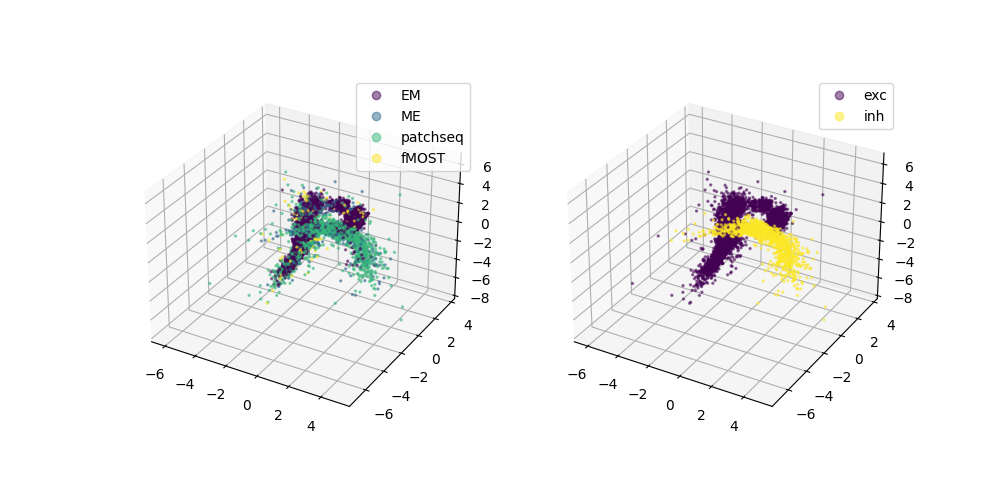

In [137]:
%matplotlib widget
fig = plt.figure(figsize = (10, 5))
ax_exp = fig.add_subplot(1, 2, 1, projection = "3d")
ax_type = fig.add_subplot(1, 2, 2, projection = "3d")
(factors_exp, labels_exp) = pd.Series(platforms2).factorize() # For legend to match color with label
(factors_type, labels_type) = pd.Series(types2).factorize() # For legend to match color with label
sc_exp = ax_exp.scatter(zm2[:, 0], zm2[:, 1], zm2[:, 2], s = 2, alpha = 0.5, 
                c = factors_exp)
sc_type = ax_type.scatter(zm2[:, 0], zm2[:, 1], zm2[:, 2], s = 2, alpha = 0.5, 
                c = factors_type)
leg_exp = ax_exp.legend(sc_exp.legend_elements()[0], labels_exp.to_list())
leg_type = ax_type.legend(sc_type.legend_elements()[0], labels_type.to_list())
plt.show()

In [121]:
with open("../data/remote/original_ian/output.pkl", "rb") as target:
    outputs = pk.load(target)
spec_ids = outputs["specimen_id"]
zm = align(outputs["zm"], spec_ids, anno_full)
types = align(outputs["class"], spec_ids, anno_full)
platforms = anno_full["platform"].to_numpy()

In [122]:
valid = ~np.any(np.isnan(zm), 1) & anno_full["M_cell"].to_numpy()
zm = zm[valid]
types = types[valid]
platforms = platforms[valid]

In [123]:
np.unique(platforms, return_counts = True)

(array(['EM', 'ME', 'fMOST', 'patchseq'], dtype=object),
 array([5009,  447,  280, 1619]))

In [124]:
umap_model = umap.UMAP(n_components = 3).fit(zm)

In [125]:
proj = umap_model.transform(zm)

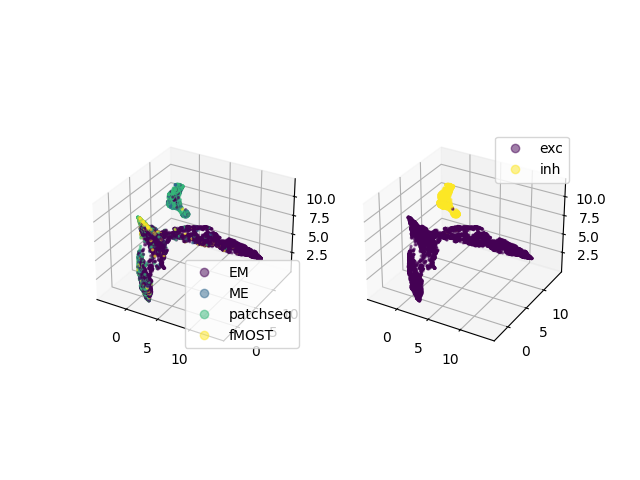

In [126]:
%matplotlib widget
fig = plt.figure()
ax_exp = fig.add_subplot(1, 2, 1, projection = "3d")
ax_type = fig.add_subplot(1, 2, 2, projection = "3d")
(factors_exp, labels_exp) = pd.Series(platforms).factorize() # For legend to match color with label
(factors_type, labels_type) = pd.Series(types).factorize() # For legend to match color with label
sc_exp = ax_exp.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s = 2, alpha = 0.5, 
                c = factors_exp)
sc_type = ax_type.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s = 2, alpha = 0.5, 
                c = factors_type)
leg_exp = ax_exp.legend(sc_exp.legend_elements()[0], labels_exp.to_list())
leg_type = ax_type.legend(sc_type.legend_elements()[0], labels_type.to_list())
plt.show()

### Raw data analysis

To gauge the degree of separation/clustering that already exists in the raw morphological data, we can train a simple linear discriminant classifier and assess its accuracy at distinguishing EM and Patch-Seq data. By enforcing equal priors across the two experiment types, we tie the accuracy of the classifier directly to how the data clusters.

In [102]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [136]:
flat_arbors = arbors.reshape((arbors.shape[0], -1)) # LDA requires flattened data
X = select(flat_arbors, anno_unnorm)
y = anno_unnorm["platform"] # Want to predict experiment type
linear = LDA(priors = [0.5, 0.5]).fit(X, y)
linear.score(select(flat_arbors, anno_samp), anno_samp["platform"])

0.6445473251028807

The low accuracy here suggests that the EM and Patch-Seq data are not trivially separable. However, the excitatory and inhibitory arbor densities were encoded into distinct slices of the data array, and can therefore be learned independently by a classifier. Let's visualize any differences between cell types by projecting the arbor densities onto the 1D subspace generated by the LDA classifier, and then plotting the excitatory and inhibitory cells separately.

In [137]:
projected_arbors = linear.transform(select(flat_arbors, anno_samp))

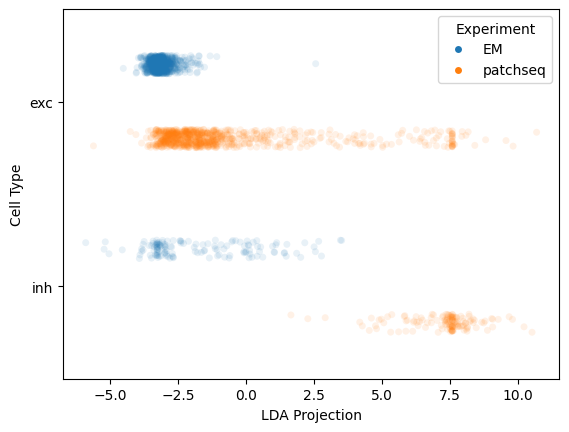

In [140]:
%matplotlib inline
plot = sns.stripplot(
    data = {"LDA Projection": projected_arbors.squeeze(), "Experiment": anno_samp["platform"], "Cell Type": anno_samp["class"]}, 
    x = "LDA Projection", y = "Cell Type", hue = "Experiment", alpha = 0.1, dodge = True)
for point in plot.legend_.legend_handles: # Remove transparency from legend symbols
    point._alpha = 1
plt.show()

We can see that the excitatory cells are more tightly clustered in the EM dataset versus Patch-Seq, but a large overlap still exists between the two experiments. Among inhibitory cells, by contrast, the two experiments form distinct clusters and are easy to separate.

One weakness of these LDA projections is that we cannot easily compare the excitatory and inhibitory cells within a single experiment type. To remedy this, we will merge the excitatory and inhibitory data slices and then create a 2D UMAP projection of the combined data.

In [106]:
arbors_comb = (arbors[..., :2] + arbors[..., 2:]).reshape((arbors.shape[0], -1)) # Merge two parts of last dimension
X_comb = select(arbors_comb, anno_unnorm)
umap_model = umap.UMAP().fit(X_comb)

In [107]:
proj = umap_model.transform(select(arbors_comb, anno_samp))

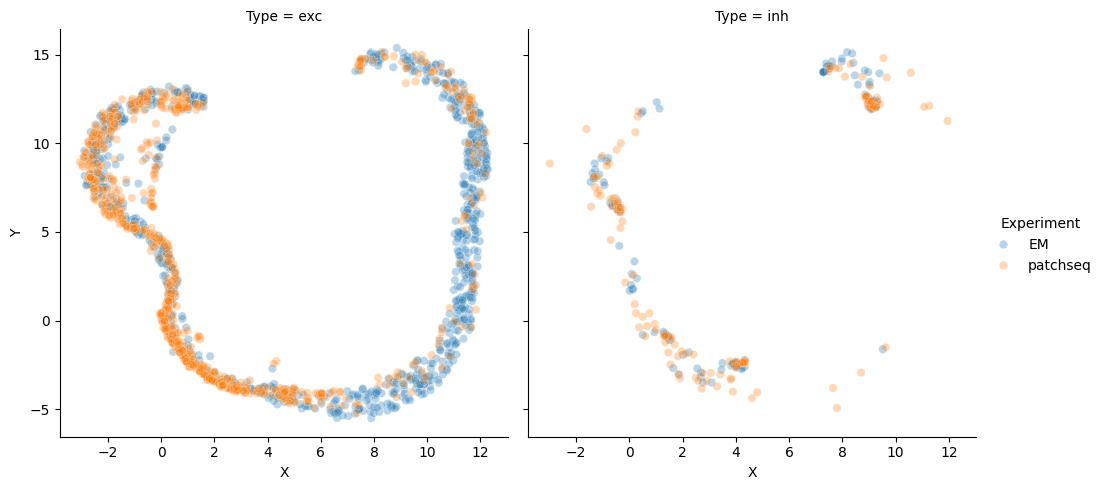

In [142]:
%matplotlib inline
plot = sns.relplot(
    data = {"X": proj[:, 0], "Y": proj[:, 1], "Experiment": anno_samp["platform"], "Type": anno_samp["class"]}, 
    x = "X", y = "Y", hue = "Experiment", col = "Type", alpha = 0.3)
plt.show()

Interestingly, the LDA and UMAP projections show different patterns. In the LDA excitatory clusters, we see that EM cells are more tightly packed than the Patch-Seq cells, while the opposite is true in the UMAP clusters. For the inhibitory cells, UMAP does not yield any real separation, while LDA is capable of significant separation. Both of these observations are likely attributable to the supervised nature LDA, which finds a projection direction in the 960-dimensional arbor space that explicitly seeks label separation (and is able to do so for excitatory and inhibitory cells independently), while UMAP tries to preserve the overall topology of the combined data even when much of it may not be useful for classification.

## Latent space analysis

Our ultimate goal is to understand the topology of the latent space in the morphology autoencoder. Given that we expect the encoder-decoder mapping to be relatively smooth, the topology of the raw data ought to be at least roughly reflected in the topology of a latent space that is optimized to reconstruct the original data. To evaluate this, we can plot the 3D latent representations of the EM and Patch-Seq experiments from a trained autoencoder.

In [109]:
# Load 3D latent space data
latent_dict = np.load("../data/remote/morpho/reference_3d/outputs.npz")
specimen_ids = latent_dict["specimen_ids"]
latent = align(latent_dict["latent_space"], latent_dict["specimen_ids"], anno_full)

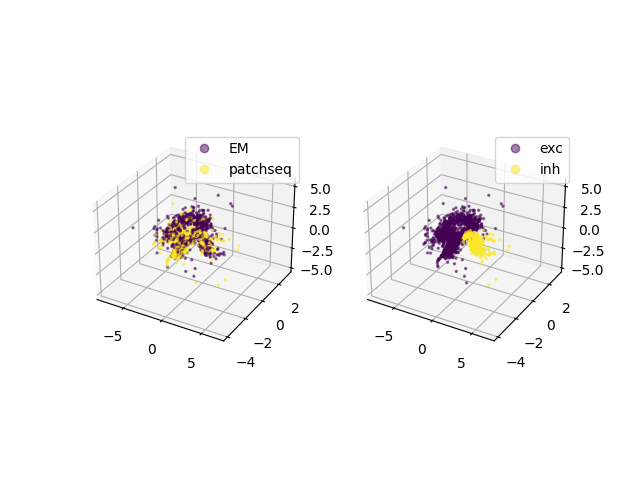

In [143]:
%matplotlib widget
latent_samp = select(latent, anno_samp)
fig = plt.figure()
ax_exp = fig.add_subplot(1, 2, 1, projection = "3d")
ax_type = fig.add_subplot(1, 2, 2, projection = "3d")
(factors_exp, labels_exp) = anno_samp["platform"].factorize() # For legend to match color with label
(factors_type, labels_type) = anno_samp["class"].factorize() # For legend to match color with label
sc_exp = ax_exp.scatter(latent_samp[:, 0], latent_samp[:, 1], latent_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_exp)
sc_type = ax_type.scatter(latent_samp[:, 0], latent_samp[:, 1], latent_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_type)
leg_exp = ax_exp.legend(sc_exp.legend_elements()[0], labels_exp.to_list())
leg_type = ax_type.legend(sc_type.legend_elements()[0], labels_type.to_list())
plt.show()

The plots shown above are consistent with our expectations. For the excitatory cells, we see the same 1D horseshoe topology as in the UMAP projections, except this time it slithers through 3D space. The distribution of EM and Patch-Seq data along the projection is also similar, with EM data spread across the entire surface while Patch-Seq is concentrated toward a single side. Looking at the inhibitory cells, we can see that they are fully separated from the excitatory cells, and do not possess any notable difference in distribution between EM and Patch-Seq.

For easier visualization, we can perform a 2D UMAP projection on the autoencoder's latent space (shown below). This makes it clear that the same horseshoe/U-shape topology exists in both the raw arbor density data and the latent space. However, since the excitatory and inhibitory data slices were separated for this autocoder experiment, the inhibitory cells are placed on their own distinct manifold.

In [111]:
proj_latent_sep = umap.UMAP().fit_transform(latent_samp)

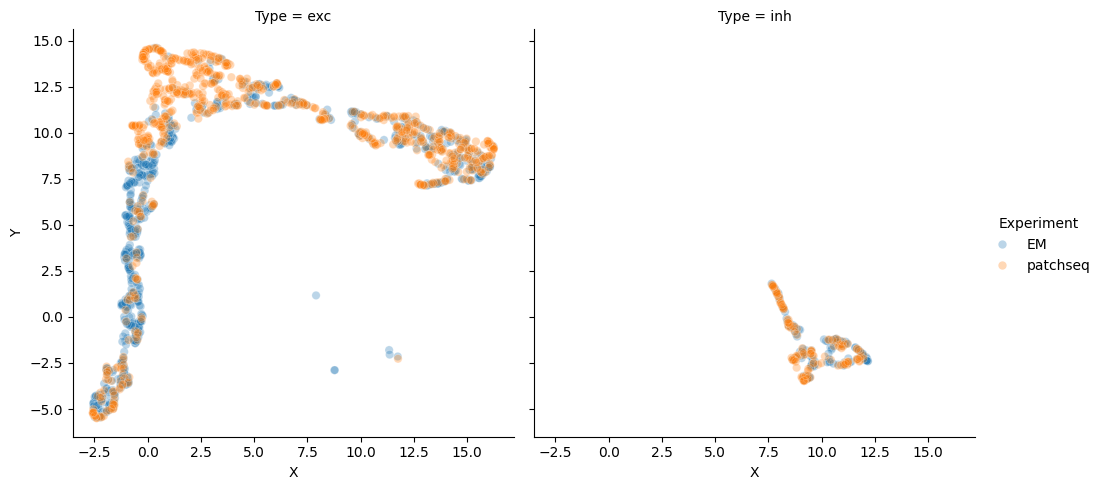

In [125]:
%matplotlib inline
plot = sns.relplot(data = {"X": proj_latent_sep[:, 0], "Y": proj_latent_sep[:, 1], "Experiment": anno_samp["platform"], 
                           "Type": anno_samp["class"]}, x = "X", y = "Y", hue = "Experiment", col = "Type", alpha = 0.3)
plt.show()

Let's now consider what happens to the latent space if we merge the excitatory and inhibitory array slices. We will create an equivalent set of plots to the ones above using a model trained on the merged arbor densities.

In [113]:
combined_dict = np.load("../data/remote/morpho/reference_stopped/outputs.npz")
latent_comb = align(combined_dict["latent_space"], combined_dict["specimen_ids"], anno_full)

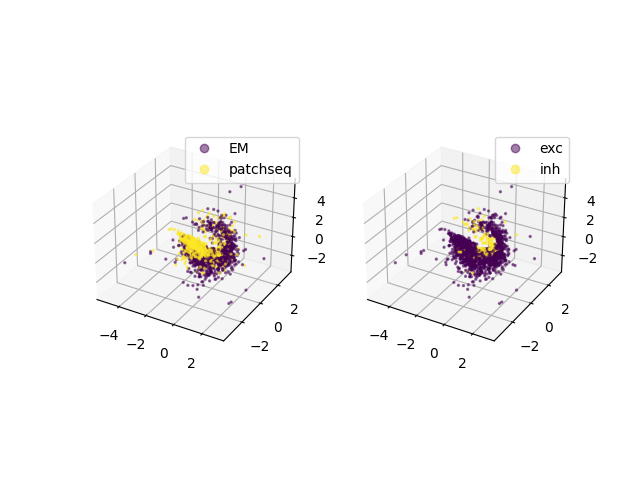

In [144]:
%matplotlib widget
latent_comb_samp = select(latent_comb, anno_samp)
fig_comb = plt.figure()
ax_comb_exp = fig_comb.add_subplot(1, 2, 1, projection = "3d") # For legend to match color with label
ax_comb_type = fig_comb.add_subplot(1, 2, 2, projection = "3d") # For legend to match color with label
(factors_comb_exp, labels_comb_exp) = anno_samp["platform"].factorize()
(factors_comb_type, labels_comb_type) = anno_samp["class"].factorize()
sc_comb_exp = ax_comb_exp.scatter(latent_comb_samp[:, 0], latent_comb_samp[:, 1], latent_comb_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_comb_exp)
sc_comb_type = ax_comb_type.scatter(latent_comb_samp[:, 0], latent_comb_samp[:, 1], latent_comb_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_comb_type)
leg_comb_exp = ax_comb_exp.legend(sc_comb_exp.legend_elements()[0], labels_comb_exp.to_list())
leg_comb_type = ax_comb_type.legend(sc_comb_type.legend_elements()[0], labels_comb_type.to_list())
plt.show()

While the latent space is a bit messier in this model, we can easily see from the right plot that excitatory and inhibitory cells are no longer separated, since we've removed the index-based indicator from the input data. From the plot on the left, we once again see a low-dimensional surface that has the same topology as the earlier UMAP projection, now with the inhibitory cells embedded as well.

We can again perform a 2D UMAP projection on the latent space for easier visualization, and see that the horseshoe topology is preserved (with both excitatory and inhibitory cells now placed on the same manifold).

In [115]:
proj_latent_comb = umap.UMAP().fit_transform(latent_comb_samp)

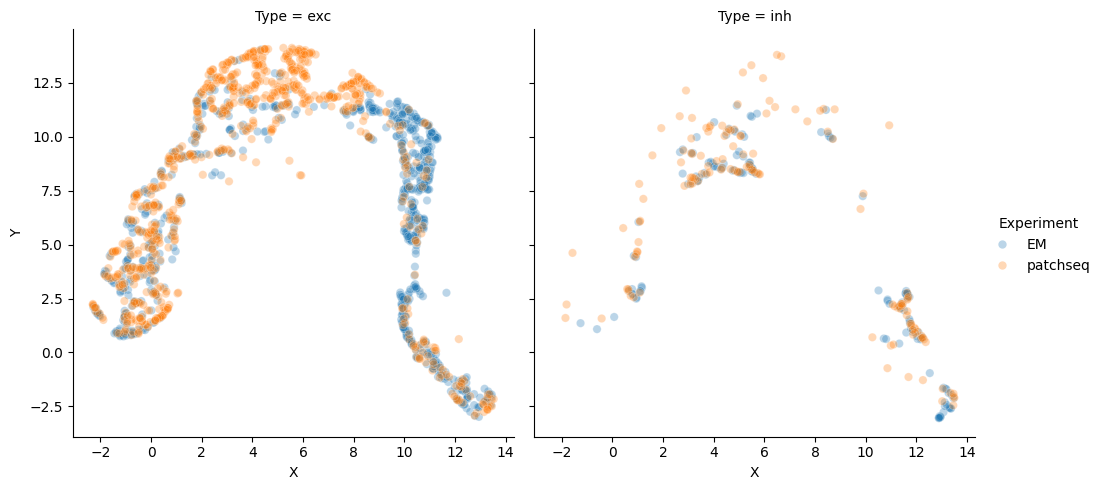

In [129]:
%matplotlib inline
plot = sns.relplot(data = {"X": proj_latent_comb[:, 0], "Y": proj_latent_comb[:, 1], "Experiment": anno_samp["platform"], 
                           "Type": anno_samp["class"]}, x = "X", y = "Y", hue = "Experiment", col = "Type", alpha = 0.3)
plt.show()